In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, sklearn, keras, gensim, multiprocessing

from pandas import read_csv
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding, BatchNormalization
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import RegexpTokenizer

In [ ]:
# Read course description data
X = read_csv('input/courses_nested.csv')

# DEFINE CONSTANTS
TEST_SIZE = 0.05   # Define split size for test, training data (% of all records)
LAM = 0.01        # Regularization parameter
EPOCHS = 40        # Number of epochs
BATCH_SIZE = 64    # Batch size

In [ ]:
# Convert softmax predictions to labels 
def undo_onehot (df, df_prime):
    # Use model to predict output
    out = np.argmax(df_prime, axis = 1)
    df = np.argmax(df, axis = 1)

    # Inverse transform using the encoder defined above
    out = le.inverse_transform(out)
    df = le.inverse_transform(df)

    # Return as data frame
    out = {'y': df,
          'y_prime': out,
          'match': (df == out) + 0}
    return pd.DataFrame(out)

In [ ]:
def model_implement(model_in, N_words, description):
    # Set seed to ensure that train, test, dev observations are identical across 
    # model runs
    np.random.seed(989)
    
    # Tokenize features - select N_words using a tf-idf algorithm
    vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features = N_words, ngram_range = (1,2))
    x = vectorizer.fit_transform(X['desc'])
    x_dense = x.toarray()

    # Split into test, training datasets. Train and dev datasets contain identical number
    # of observations
    train_X, test_X, train_Y, test_Y = train_test_split(x_dense, y_onehot, test_size = TEST_SIZE,
                                                        shuffle = True, stratify = y_onehot)
    train_X, dev_X, train_Y, dev_Y = train_test_split(train_X, train_Y, test_size = TEST_SIZE / (1 - TEST_SIZE),
                                                      shuffle = True, stratify = train_Y)

    # Compile model defined and entered as function argument, use ADAM optimizer.
    # Output is categorical, use categorical cross-entropy loss function
    model_in.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # Test model fit using mini-batch gradient descent
    test_fit = model_in.fit(x = train_X, y = train_Y, validation_data = (dev_X, dev_Y),
                            epochs = EPOCHS, batch_size = BATCH_SIZE)

    # Calculate prediction accuracy in train, dev, test sets
    train_accuracy = model_in.evaluate(train_X, train_Y)[1]
    dev_accuracy = model_in.evaluate(dev_X, dev_Y)[1]
    test_accuracy = model_in.evaluate(test_X, test_Y)[1]
    out = {'data': ['train', 'dev', 'test'],
           'accuracy': [train_accuracy, dev_accuracy, test_accuracy],
           'desc': description}
    out = pd.DataFrame.from_dict(out)

    return x_dense, test_fit, model_in, out

In [ ]:
# Create one-hot vector encoding for classification vector y
le = LabelEncoder() 
onehot_encoder = OneHotEncoder(sparse = False)
y_v2 = le.fit_transform(np.array(X['blom_group']))
y_v2 = y_v2.reshape(len(y_v2), 1)
y_onehot = onehot_encoder.fit_transform(y_v2)

In [ ]:
##########################################
# DEFINE MODEL - multilayer sequential model with
# regularization to avoid overfitting on individual words,
# final activation function should be a softmax activation
# where the number of nodes corresponds to the number of 
# distinct major categories
##########################################

N = 2500

model = Sequential()
model.add(Dense(1152, input_dim = N, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model.add(BatchNormalization())
model.add(Dense(576, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model.add(BatchNormalization())
model.add(Dense(288, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model.add(BatchNormalization())
model.add(Dense(144, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model.add(BatchNormalization())
model.add(Dense(72, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model.add(BatchNormalization())
model.add(Dense(72, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model.add(BatchNormalization())
model.add(Dense(36, activation = 'softmax'))

# Run model
X1, test_fit1, model1, out1 = model_implement(model, N, 'Base Model')

In [ ]:
##########################################
# MODEL 2 - Add additional layers
##########################################

N = 2500

model2 = Sequential()
model2.add(Dense(1152, input_dim = N, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model2.add(BatchNormalization())
model2.add(Dense(576, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model2.add(BatchNormalization())
model2.add(Dense(576, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model2.add(BatchNormalization())
model2.add(Dense(288, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model2.add(BatchNormalization())
model2.add(Dense(288, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model2.add(BatchNormalization())
model2.add(Dense(144, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model2.add(BatchNormalization())
model2.add(Dense(72, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model2.add(BatchNormalization())
model2.add(Dense(72, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model2.add(BatchNormalization())
model2.add(Dense(36, activation = 'softmax'))

# Run model
X2, test_fit2, model2, out2 = model_implement(model2, N, 'Additional Layers')


In [ ]:
##########################################
# MODEL 3 - Larger feature space
##########################################

N = 5000

model3 = Sequential()
model3.add(Dense(1152, input_dim = N, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model3.add(BatchNormalization())
model3.add(Dense(576, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model3.add(BatchNormalization())
model3.add(Dense(288, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model3.add(BatchNormalization())
model3.add(Dense(144, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model3.add(BatchNormalization())
model3.add(Dense(72, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model3.add(BatchNormalization())
model3.add(Dense(72, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(LAM)))
model3.add(BatchNormalization())
model3.add(Dense(36, activation = 'softmax'))

# Run model
X3, test_fit3, model3, out3 = model_implement(model3, N, 'Expand features space')

In [ ]:
########################
# DIAGNOSTICS
########################
# Compile performance compare data frame
out_append = out1.append(out2)
out_append = out_append.append(out3).reindex(columns = ['data', 'desc', 'accuracy'])
print(pd.DataFrame.to_latex(out_append))

In [ ]:
# Choose top-performing model
best_fit = test_fit1
best_model = model1
best_X = X1

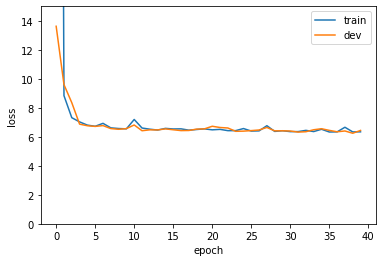

In [89]:
# Plot performance of top-performing model
plt.plot(best_fit.history['loss'])
plt.plot(best_fit.history['val_loss'])
# plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.ylim((0, 15))
# plt.show()

# Save output
# fig = plt.figure()
plt.savefig('intermediate/loss_function.png', bbox_inches='tight', dpi=150)

In [ ]:
# Evaluate performance of the model by department category
# test_out = undo_onehot(df = y_onehot, df_prime = model.predict(best_X))
test_out2 = test_out.groupby('y').mean()
test_out2['match'] = np.round(test_out2['match'], 2)

# Count observations by department
test_out2['count'] = test_out.groupby('y').count()['match']
test_out2 = test_out2.rename(columns = {'match':'accuracy'}).reindex(columns = ['count', 'accuracy'])
print(pd.DataFrame.to_latex(test_out2))

In [ ]:
# Evaluate performance by department, type of school
test_out_4year = undo_onehot(df = y_onehot[X['type'] != 'Public, 2-year'], 
                             df_prime = model.predict(best_X[X['type'] != 'Public, 2-year']))
test_out_4year = test_out_4year.groupby('y').mean()
test_out_4year['match'] = np.round(test_out_4year['match'], 2)
test_out_4year = test_out_4year.rename(columns = {'match':'4-year Accuracy'})

test_out_2year = undo_onehot(df = y_onehot[X['type'] == 'Public, 2-year'], 
                             df_prime = model.predict(best_X[X['type'] == 'Public, 2-year']))
test_out_2year = test_out_2year.groupby('y').mean()
test_out_2year['match'] = np.round(test_out_2year['match'], 2)
test_out_2year = test_out_2year.rename(columns = {'match':'2-year Accuracy'})

In [ ]:
test_out_compare = pd.merge(test_out_4year, test_out_2year, on = 'y', how = 'left')
print(pd.DataFrame.to_latex(test_out_compare))